In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, accuracy_score, median_absolute_error,mean_squared_log_error
from sklearn.feature_selection import RFECV
import lightgbm as lgb
import graphviz
from sklearn.dummy import DummyRegressor
import dalex as dx
import shap
from explainerdashboard import ClassifierExplainer, RegressionExplainer,ExplainerDashboard
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Load Dataset

In [35]:
generalStats_pos = pd.read_csv('E:/Inzynierka/generalStats_pos - generalStats_pos.csv')

Data Cleaning

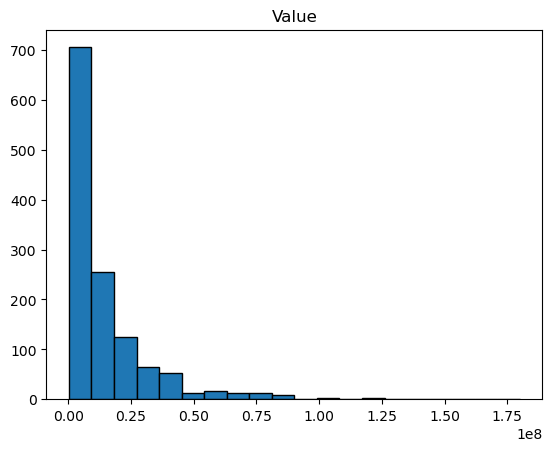

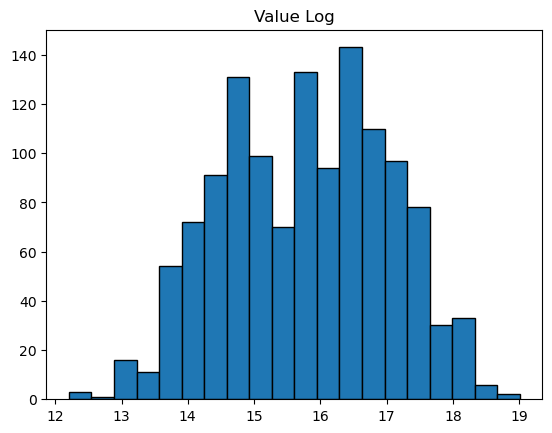

In [36]:
generalStats_pos['value_log'] = generalStats_pos['value'].apply(lambda x: math.log(x))
generalStats_pos = generalStats_pos.dropna()
sorted_data = np.sort(generalStats_pos['value'])
plt.hist(sorted_data, edgecolor='black', bins=20)
plt.title('Value')
plt.show()

sorted_data = np.sort(generalStats_pos['value_log'])
plt.hist(sorted_data, edgecolor='black', bins=20)
plt.title('Value Log')
plt.show()

In [37]:
def calculate_revised_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    msle = mean_squared_log_error(y_true, y_pred)
    median_ae = median_absolute_error(y_true, y_pred)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R^2": r2,
        "MAPE": mape,
        "MSLE": msle,
        "Median AE": median_ae
    }

In [38]:
X = generalStats_pos.iloc[:, 3:-2]
y = generalStats_pos.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

modelling

In [39]:
model = lgb.LGBMRegressor()
model.fit(X_train,y_train)
score = model.score(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('Score: ', score)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2707
[LightGBM] [Info] Number of data points in the train set: 1019, number of used features: 41
[LightGBM] [Info] Start training from score 15.812169
Score:  0.9808312655330469


In [40]:
%%capture
estimated_value_log = []
generalStats_pos_local = generalStats_pos.copy()
for i in range(0,len(generalStats_pos_local)):
    player_data = generalStats_pos_local.iloc[i,:].to_frame().transpose()
    player_data = (player_data.iloc[:, 3:-2])
    print(player_data)
    estimated_value_log.append(float(model.predict(player_data.apply(pd.to_numeric, errors='coerce', downcast='float'))))


<class 'pandas.core.series.Series'>
0       0.26
1       0.51
2       0.09
3       0.27
4       0.20
        ... 
1310    0.03
1311   -1.05
1314   -1.98
1315   -0.65
1316   -0.48
Name: diff_log, Length: 1274, dtype: float64
<class 'pandas.core.series.Series'>
0      41008712.41
1      59911586.14
2      10857498.55
3      28672173.86
4      20142171.47
           ...    
1310      12196.64
1311    -555358.67
1314   -1250922.60
1315    -182482.26
1316    -123920.06
Name: diff, Length: 1274, dtype: float64
                             Player      value  estimated_value         diff  \
1                   Vinicius Júnior  150000000      90088413.86  59911586.14   
34                     Éder Militão   70000000      11579137.58  58420862.42   
18                   Enzo Fernández   80000000      35946182.46  44053817.54   
5                             Pedri  100000000      57968281.98  42031718.02   
0                    Erling Haaland  180000000     138991287.59  41008712.41   
27        

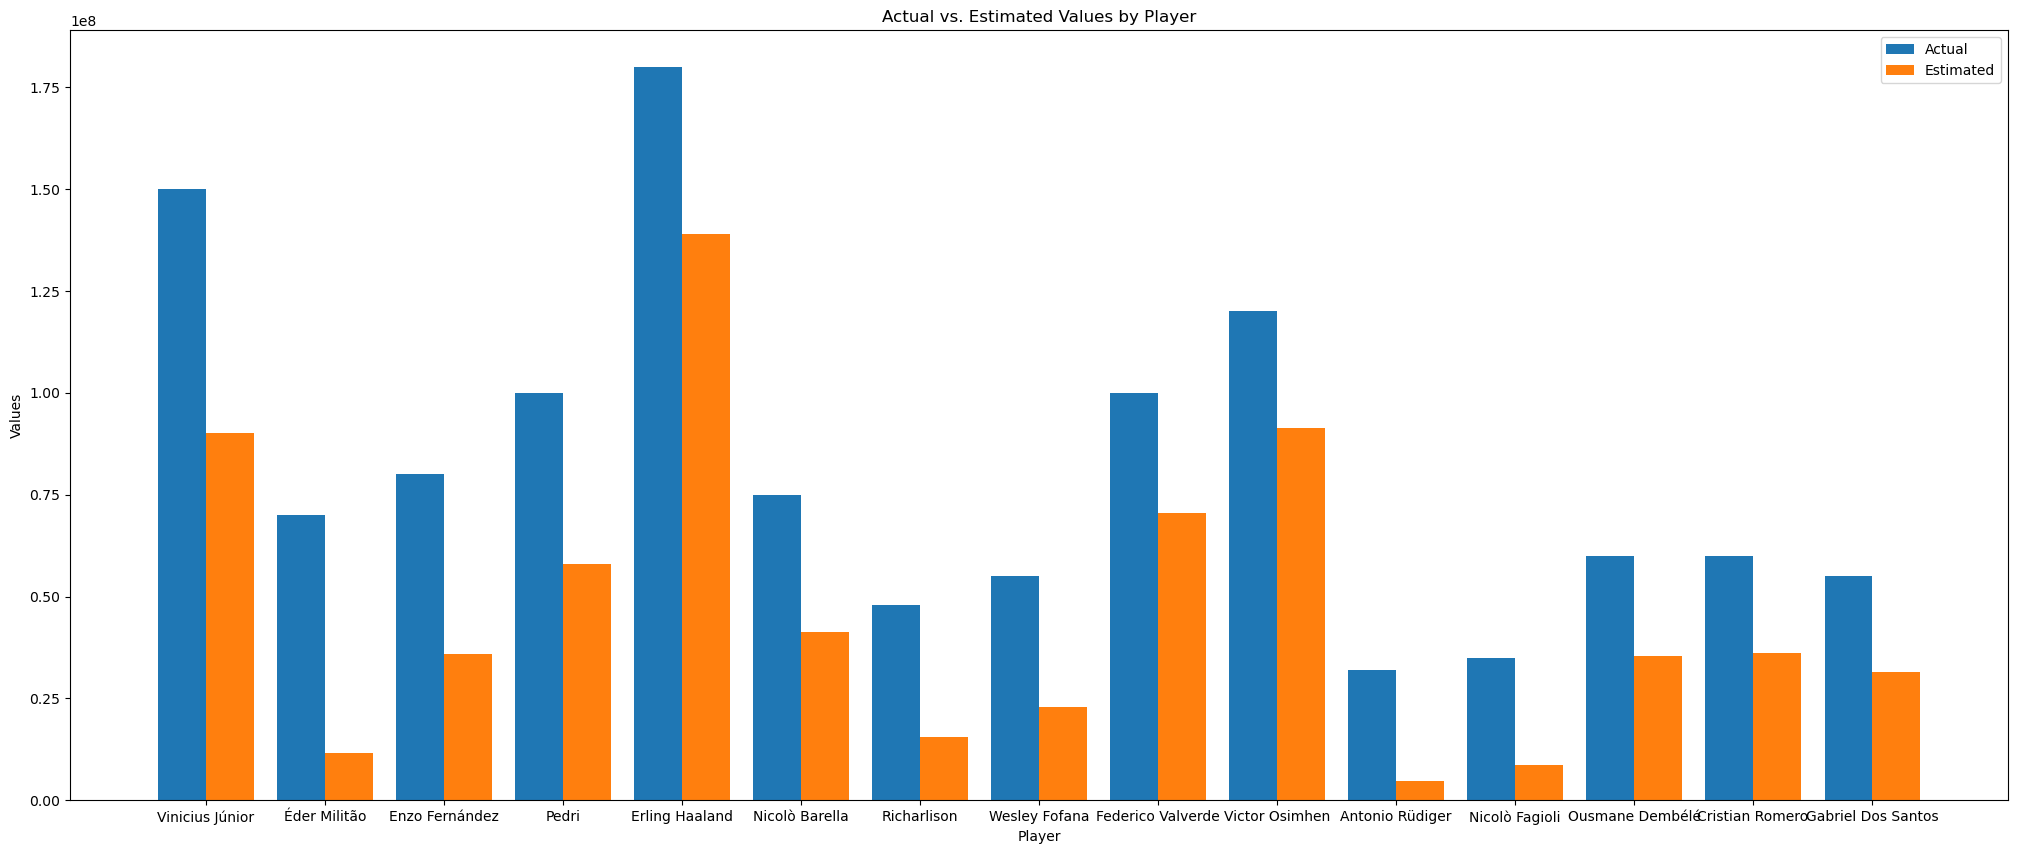

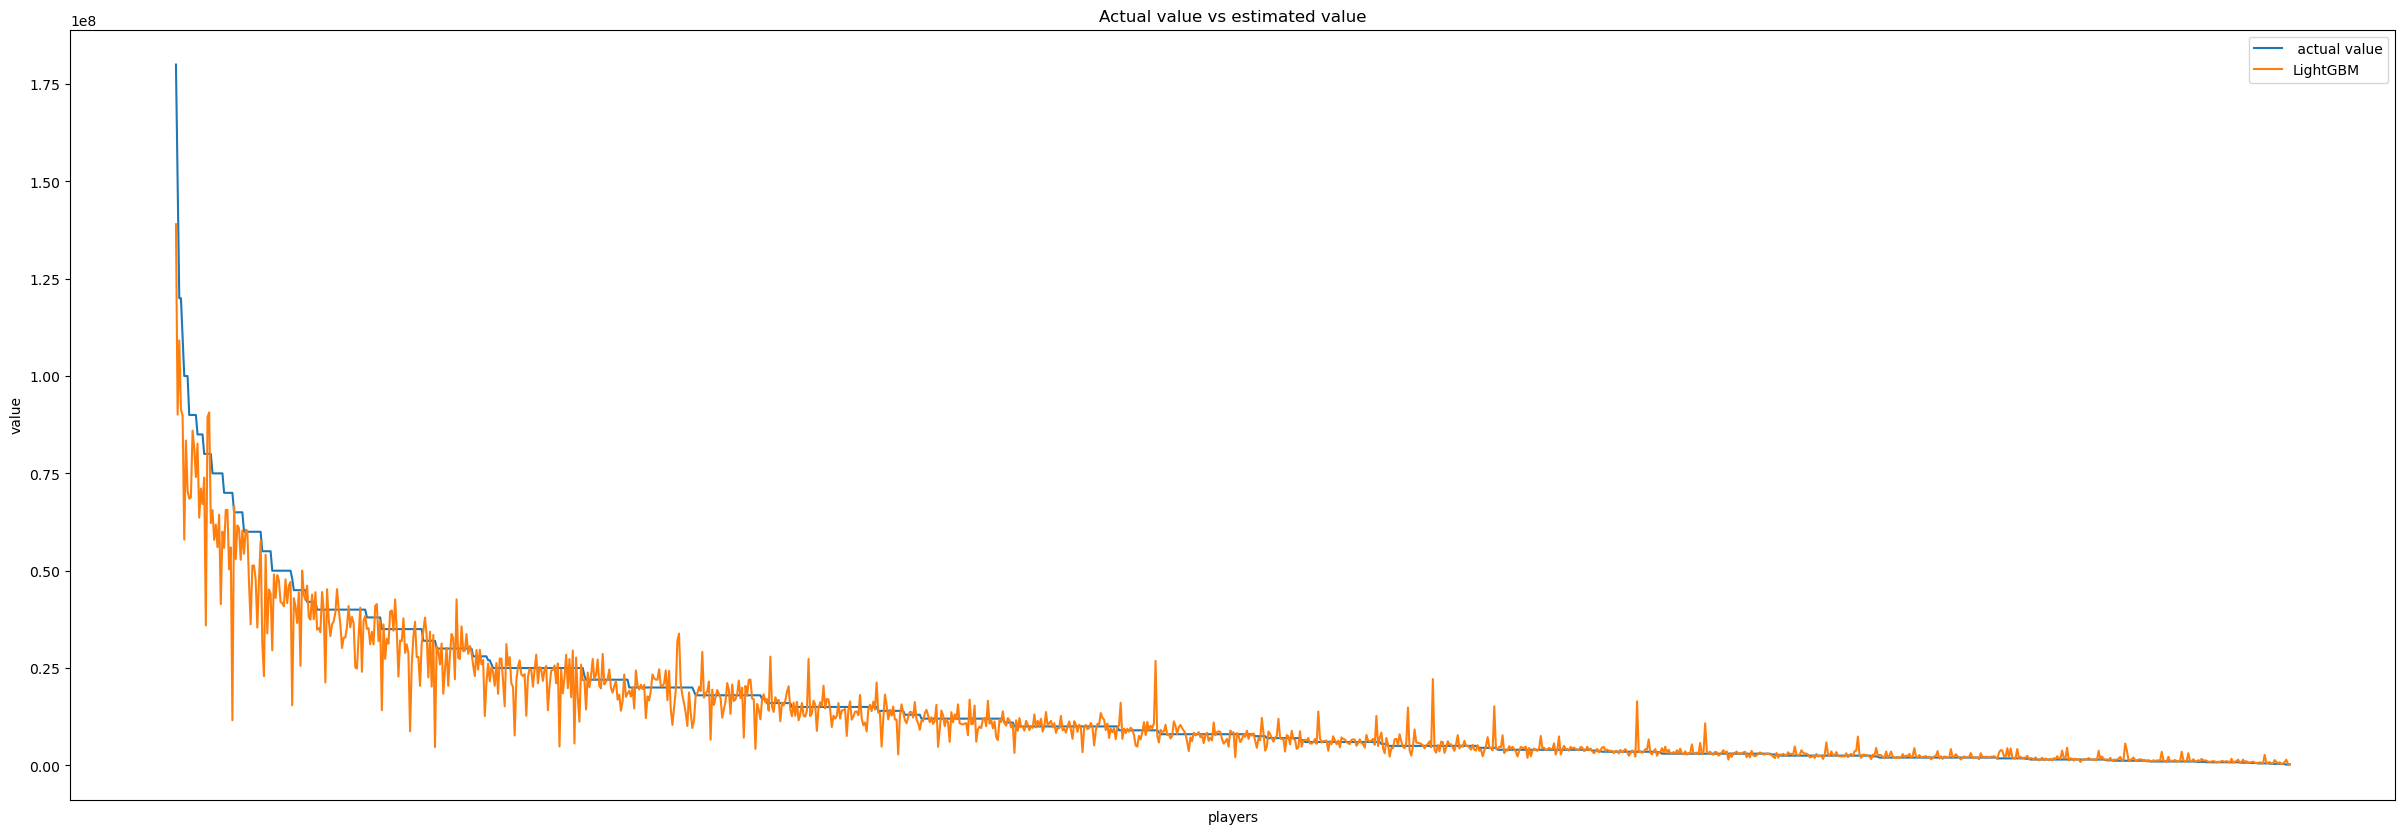

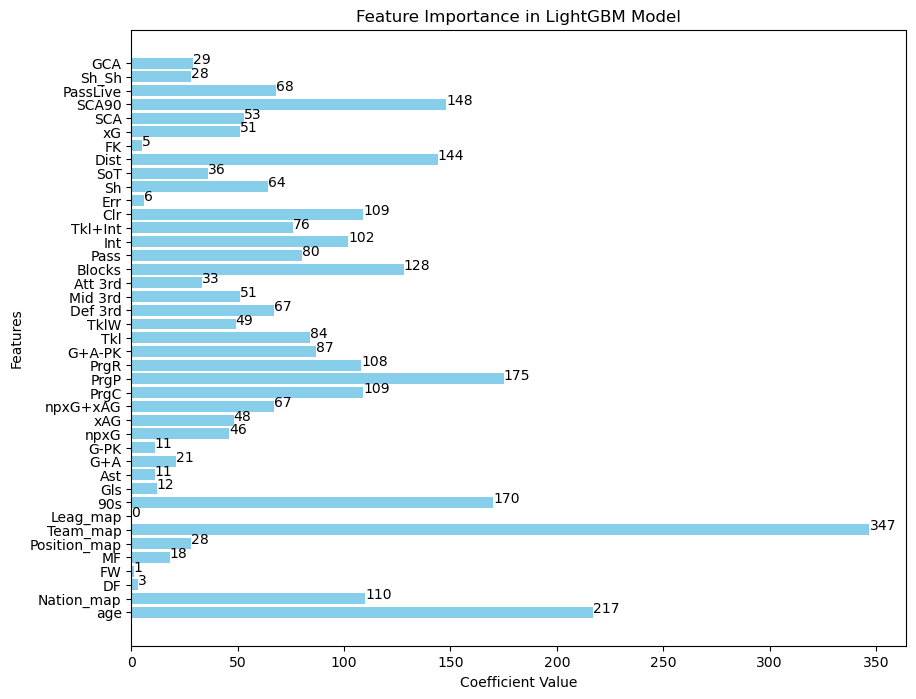

In [41]:

estimated_value = []
generalStats_pos_local['estimated_value_log'] = estimated_value_log
generalStats_pos_local['estimated_value_log'] = generalStats_pos_local['estimated_value_log'].astype(float)
print(type(generalStats_pos_local['estimated_value_log']))
generalStats_pos_local['diff_log'] = generalStats_pos_local['value_log'] - generalStats_pos_local['estimated_value_log']
print(generalStats_pos_local['diff_log'])

for value in generalStats_pos_local['estimated_value_log']:
    estimated_value.append(math.exp(value))
generalStats_pos_local['estimated_value'] = estimated_value
generalStats_pos_local['value'] = generalStats_pos_local['value'].astype(int)
generalStats_pos_local['diff'] = generalStats_pos_local['value'] - generalStats_pos_local['estimated_value']
print(type(generalStats_pos_local['value']))
print(generalStats_pos_local['diff'])

generalStats_pos_local['absolute_diff'] = abs(generalStats_pos_local['diff'])

bestvalued_50 = generalStats_pos_local[['Player','value','estimated_value','diff','absolute_diff']].nlargest(n=50,columns = 'absolute_diff')
print(bestvalued_50)
actual_values = bestvalued_50.head(15)['value']
estimated_values = bestvalued_50.head(15)['estimated_value']
labels = bestvalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels) 
print('Mean difference: ', np.mean(generalStats_pos_local['absolute_diff']))
plt.legend()

plt.show()
plt.figure(figsize=(30, 10))  
plt.xlabel('players')
plt.ylabel('value')
plt.title('Actual value vs estimated value')
plt.xticks([])
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['value'], label=' actual value')
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['estimated_value'], label='LightGBM')


plt.legend()
plt.show()
coefficients = model.feature_importances_

# Assuming feature names are like 'feature1', 'feature2', etc.
feature_names = generalStats_pos.iloc[:, 3:-2].columns.tolist()

# Step 4: Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, coefficients, color='skyblue')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance in LightGBM Model')

# Adding the coefficient values on the bars
for index, value in enumerate(coefficients):
    ax.text(value, index, str(round(value, 2)))

plt.show()

In [42]:
metrics = calculate_revised_metrics(y_test, y_test_pred)
print(metrics)

{'MAE': 0.4995649767592296, 'MSE': 0.40617702289568614, 'RMSE': 0.6373201886773132, 'R^2': 0.7430038663599777, 'MAPE': 3.2339807285428868, 'MSLE': 0.0015130991274990362, 'Median AE': 0.41050932687898367}


perform RFE on LightGBM

In [43]:
"""%%capture
estimator = lgb.LGBMRegressor()
selector = RFECV(estimator, cv=10)
selector = selector.fit(X_train, y_train)

print("Suggested number of features: %d" % selector.n_features_)
print("Selected features: %s" % selector.support_)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
"""

'%%capture\nestimator = lgb.LGBMRegressor()\nselector = RFECV(estimator, cv=10)\nselector = selector.fit(X_train, y_train)\n\nprint("Suggested number of features: %d" % selector.n_features_)\nprint("Selected features: %s" % selector.support_)\nX_train_selected = selector.transform(X_train)\nX_test_selected = selector.transform(X_test)\n'

In [44]:
"""selected_fetures = []
keys = generalStats_pos.iloc[:, 3:-2].keys()
for i in range(0,len(selector.support_)-1):
    if selector.support_[i] == True:
        selected_fetures.append(keys[i])
print(selected_fetures)
print(X_train_selected)
"""
selected_features = ['age', 'Nation_map', 'Team_map', '90s', 'PrgC', 'PrgP', 'PrgR', 'G+A-PK', 'Blocks', 'Int', 'Tkl+Int', 'Sh', 'Dist', 'SCA90']

In [45]:
selected_fetures = ['age', 'Team_map', '90s', 'G+A', 'npxG+xAG', 'PrgP', 'PassLive']
X_train_selected = X_train[selected_fetures]
X_test_selected =X_test[selected_fetures]

model = lgb.LGBMRegressor()
model.fit(X_train_selected,y_train)
score = model.score(X_train_selected,y_train)
y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)
print('Score: ', score)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 1019, number of used features: 7
[LightGBM] [Info] Start training from score 15.812169
Score:  0.9380511464783735


In [46]:
%%capture
estimated_value_log = []
generalStats_pos_local = generalStats_pos.copy()
for i in range(0,len(generalStats_pos_local)):
    player_data = generalStats_pos_local.iloc[i,:].to_frame().transpose()
    player_data = player_data[selected_fetures]
    print(player_data)
    estimated_value_log.append(float(model.predict(player_data.apply(pd.to_numeric, errors='coerce', downcast='float'))))


<class 'pandas.core.series.Series'>
0       0.44
1       0.41
2       0.14
3       0.32
4       0.21
        ... 
1310   -0.17
1311   -1.14
1314   -1.98
1315   -0.89
1316   -1.11
Name: diff_log, Length: 1274, dtype: float64
<class 'pandas.core.series.Series'>
0      63788724.95
1      50489428.48
2      15421827.68
3      32448882.30
4      20967971.79
           ...    
1310     -74638.64
1311    -638299.63
1314   -1248283.66
1315    -285041.30
1316    -405013.68
Name: diff, Length: 1274, dtype: float64
                  Player      value  estimated_value         diff  \
0         Erling Haaland  180000000     116211275.05  63788724.95   
1        Vinicius Júnior  150000000      99510571.52  50489428.48   
34          Éder Militão   70000000      24544649.85  45455350.15   
8             Harry Kane   90000000      47726699.48  42273300.52   
53         Wesley Fofana   55000000      13281860.57  41718139.43   
5                  Pedri  100000000      61803608.72  38196391.28   
7      

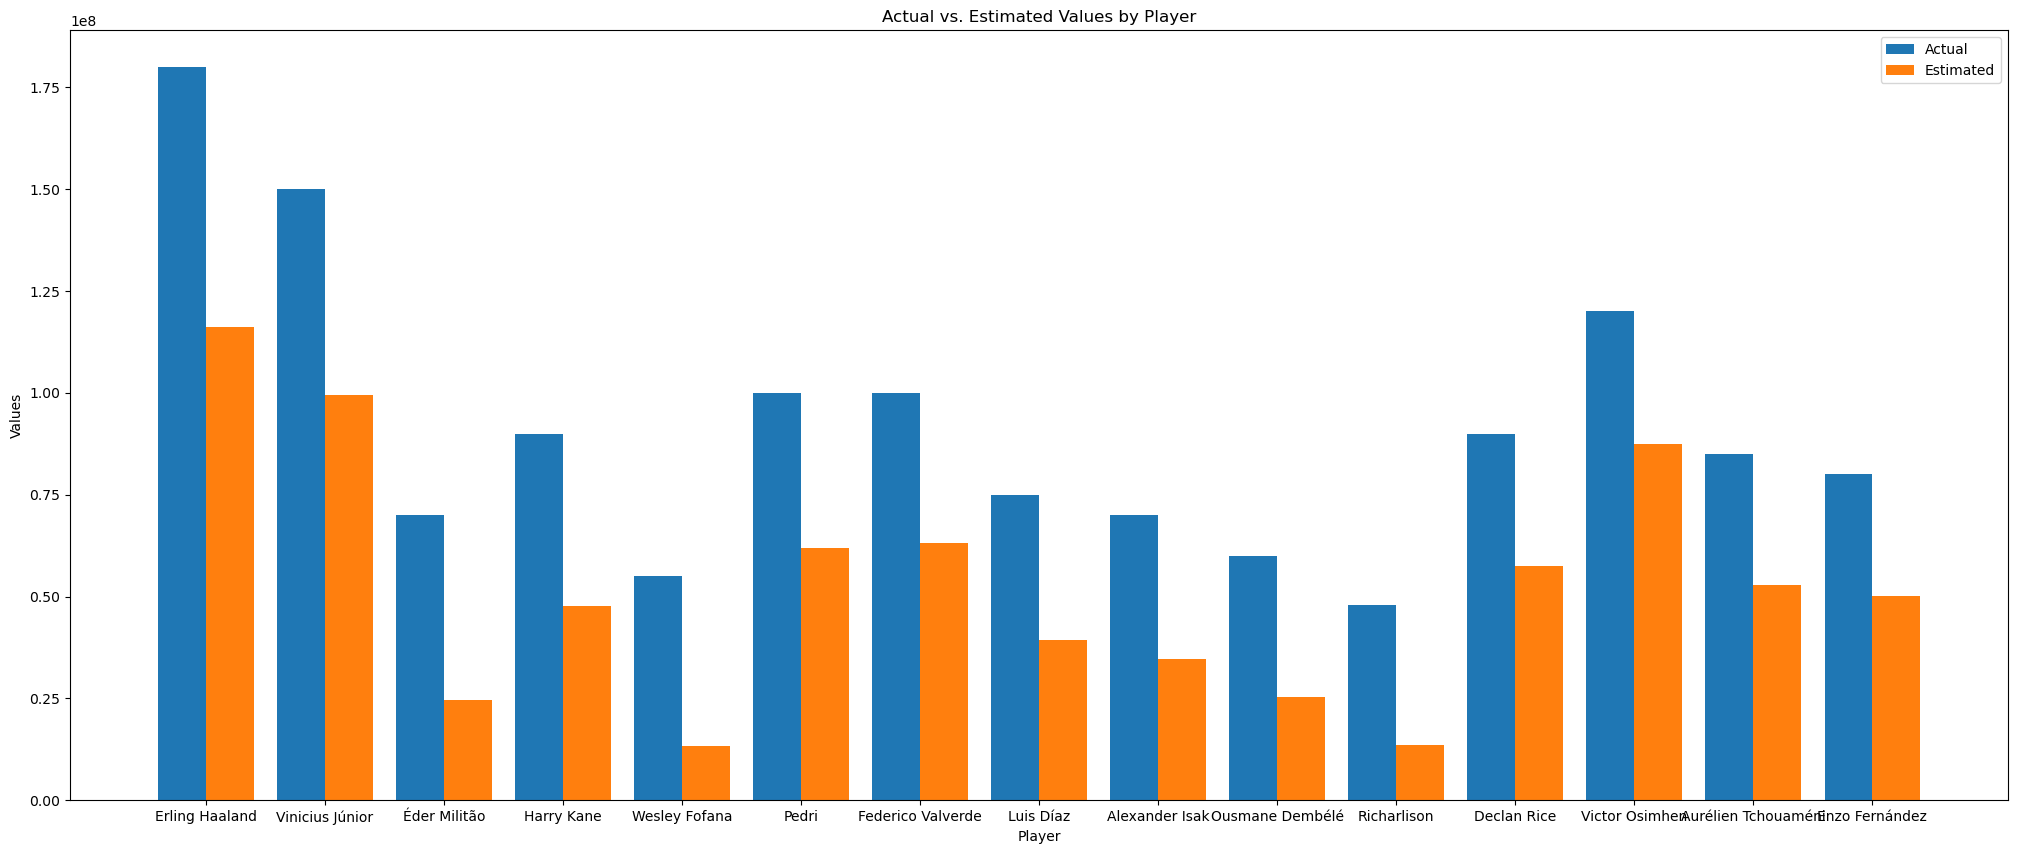

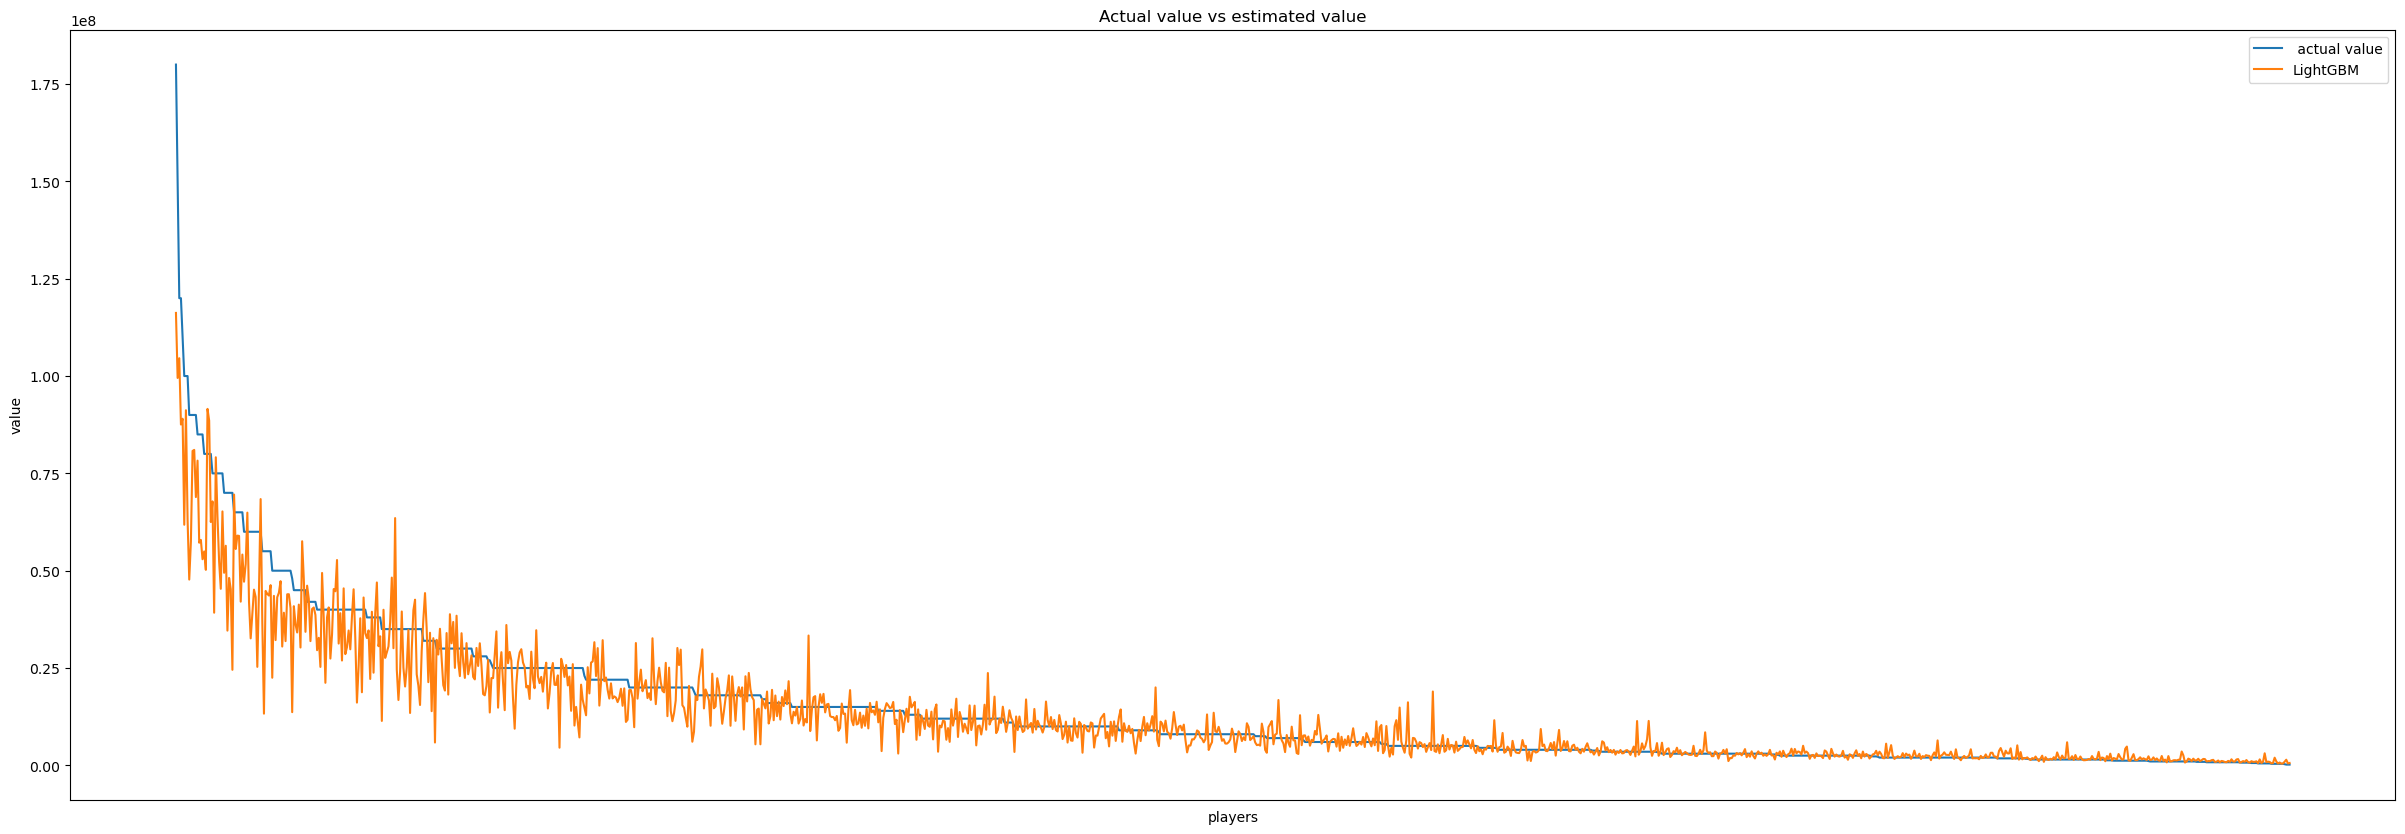

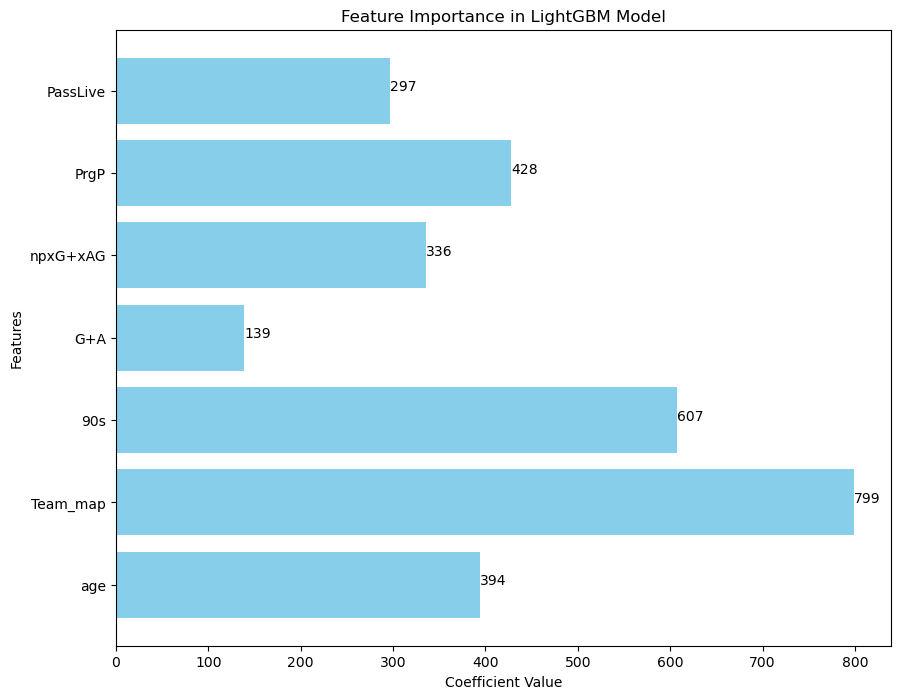

In [47]:

estimated_value = []
generalStats_pos_local['estimated_value_log'] = estimated_value_log
generalStats_pos_local['estimated_value_log'] = generalStats_pos_local['estimated_value_log'].astype(float)
print(type(generalStats_pos_local['estimated_value_log']))
generalStats_pos_local['diff_log'] = generalStats_pos_local['value_log'] - generalStats_pos_local['estimated_value_log']
print(generalStats_pos_local['diff_log'])

for value in generalStats_pos_local['estimated_value_log']:
    estimated_value.append(math.exp(value))
generalStats_pos_local['estimated_value'] = estimated_value
generalStats_pos_local['value'] = generalStats_pos_local['value'].astype(int)
generalStats_pos_local['diff'] = generalStats_pos_local['value'] - generalStats_pos_local['estimated_value']
print(type(generalStats_pos_local['value']))
print(generalStats_pos_local['diff'])

generalStats_pos_local['absolute_diff'] = abs(generalStats_pos_local['diff'])

bestvalued_50 = generalStats_pos_local[['Player','value','estimated_value','diff','absolute_diff']].nlargest(n=50,columns = 'absolute_diff')
print(bestvalued_50)
actual_values = bestvalued_50.head(15)['value']
estimated_values = bestvalued_50.head(15)['estimated_value']
labels = bestvalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels) 
print('Mean difference: ', np.mean(generalStats_pos_local['absolute_diff']))
plt.legend()

plt.show()
plt.figure(figsize=(30, 10))  
plt.xlabel('players')
plt.ylabel('value')
plt.title('Actual value vs estimated value')
plt.xticks([])
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['value'], label=' actual value')
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['estimated_value'], label='LightGBM')


plt.legend()
plt.show()
coefficients = model.feature_importances_

# Assuming feature names are like 'feature1', 'feature2', etc.
feature_names = selected_fetures

# Step 4: Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, coefficients, color='skyblue')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance in LightGBM Model')

# Adding the coefficient values on the bars
for index, value in enumerate(coefficients):
    ax.text(value, index, str(round(value, 2)))

plt.show()

In [48]:
metrics = calculate_revised_metrics(y_test, y_test_pred)
print(metrics)

{'MAE': 0.4855260615436805, 'MSE': 0.3840731608269912, 'RMSE': 0.6197363639701895, 'R^2': 0.756989411503987, 'MAPE': 3.1515549169923953, 'MSLE': 0.001448361974058383, 'Median AE': 0.3807073322857093}


Perform tuning

In [49]:
""" %%capture
param_grid = {
    'num_leaves': [5,11,31,41,51,61], 
    'max_depth': [-1,20, 30, 60],
    'min_child_samples': [5, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5],
}

grid_search = GridSearchCV(lgb.LGBMRegressor(n_estimators=100), param_grid, cv=5, scoring='r2')
 """


" %%capture\nparam_grid = {\n    'num_leaves': [5,11,31,41,51,61], \n    'max_depth': [-1,20, 30, 60],\n    'min_child_samples': [5, 10, 20, 30],\n    'learning_rate': [0.01, 0.05, 0.1],\n    'reg_alpha': [0.0, 0.1, 0.5, 1.0],\n    'reg_lambda': [0.0, 0.1, 0.5],\n}\n\ngrid_search = GridSearchCV(lgb.LGBMRegressor(n_estimators=100), param_grid, cv=5, scoring='r2')\n "

In [50]:
best_params = {'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 5, 'num_leaves': 11, 'reg_alpha': 0.5, 'reg_lambda': 0.1}
model = lgb.LGBMRegressor(**best_params)
model.fit(X_train_selected,y_train)
score = model.score(X_train_selected,y_train)
y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)
print('Score: ', score)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 1019, number of used features: 7
[LightGBM] [Info] Start training from score 15.812169
Score:  0.877699903098246


In [51]:
%%capture
estimated_value_log = []
generalStats_pos_local = generalStats_pos.copy()
for i in range(0,len(generalStats_pos_local)):
    player_data = generalStats_pos_local.iloc[i,:].to_frame().transpose()
    player_data = player_data[selected_fetures]
    print(player_data)
    estimated_value_log.append(float(model.predict(player_data.apply(pd.to_numeric, errors='coerce', downcast='float'))))

<class 'pandas.core.series.Series'>
0       0.29
1       0.26
2       0.08
3       0.45
4       0.26
        ... 
1310    0.04
1311   -1.21
1314   -1.94
1315   -0.66
1316   -0.54
Name: diff_log, Length: 1274, dtype: float64
<class 'pandas.core.series.Series'>
0      45561000.48
1      34260996.91
2       9596900.20
3      43637738.69
4      25195450.13
           ...    
1310      16199.60
1311    -701180.44
1314   -1192940.98
1315    -186270.98
1316    -144210.80
Name: diff, Length: 1274, dtype: float64
                      Player      value  estimated_value         diff  \
23                 Luis Díaz   75000000      27312361.90  47687638.10   
33             Ronald Araújo   70000000      22512270.53  47487729.47   
0             Erling Haaland  180000000     134438999.52  45561000.48   
3             Victor Osimhen  120000000      76362261.31  43637738.69   
7          Federico Valverde  100000000      58057019.16  41942980.84   
34              Éder Militão   70000000      2919543

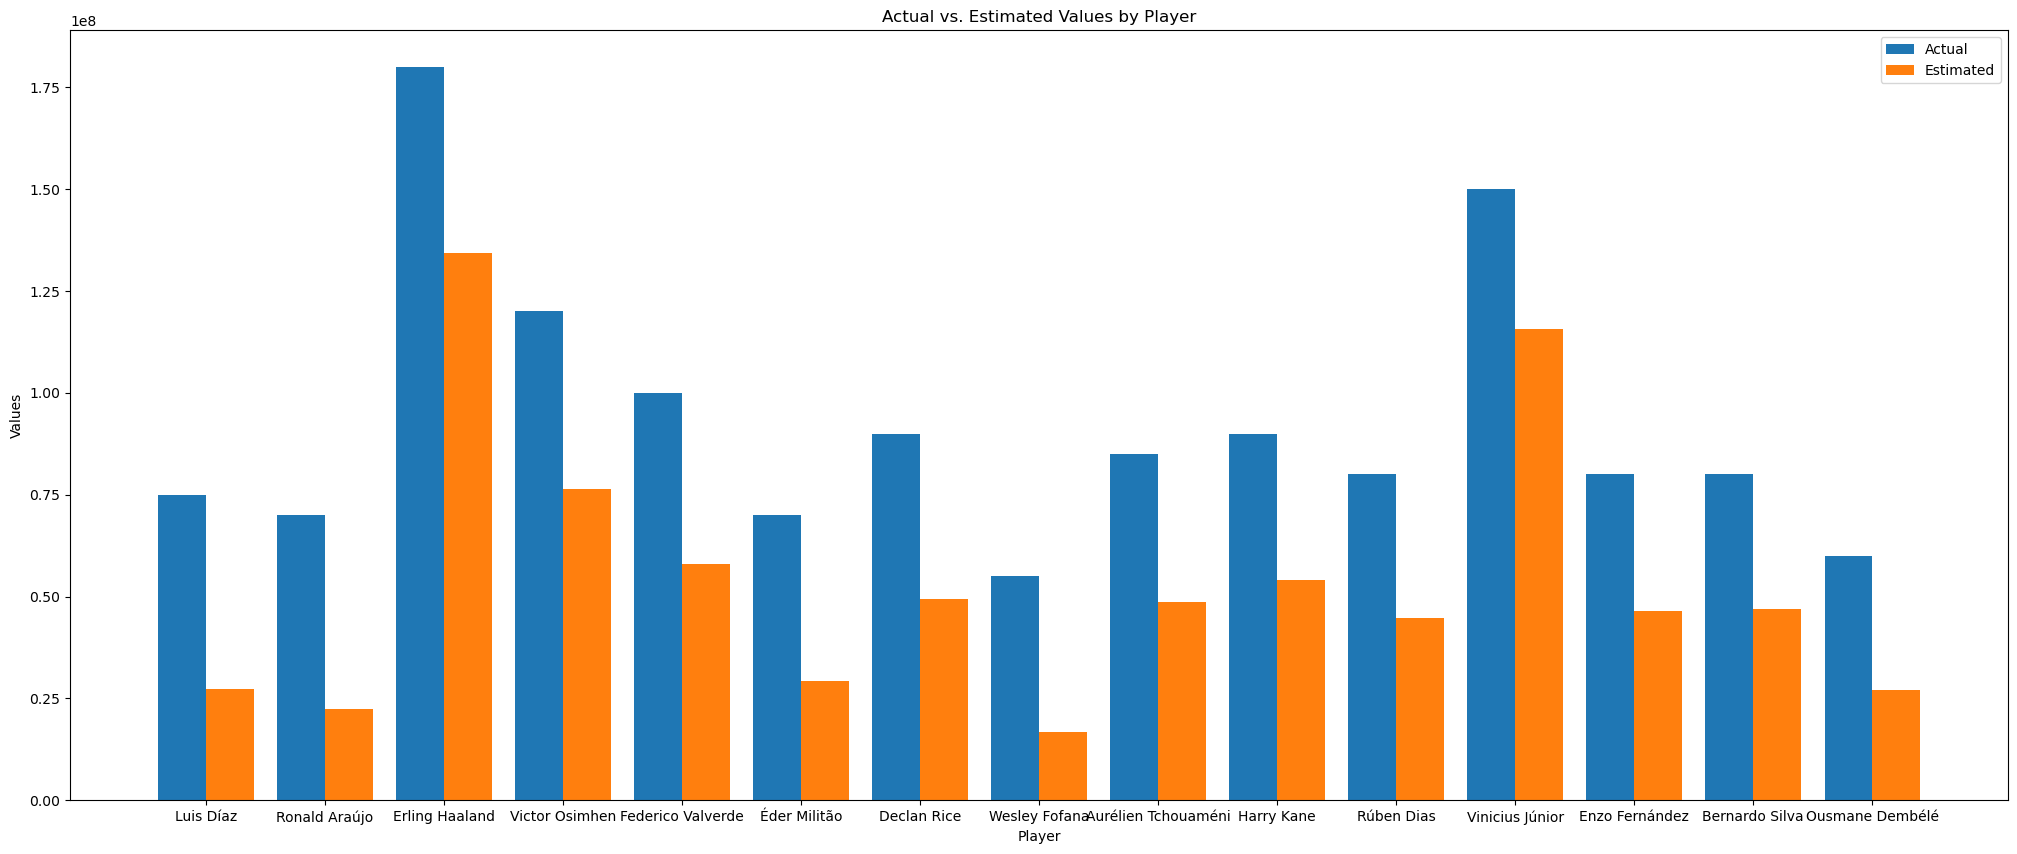

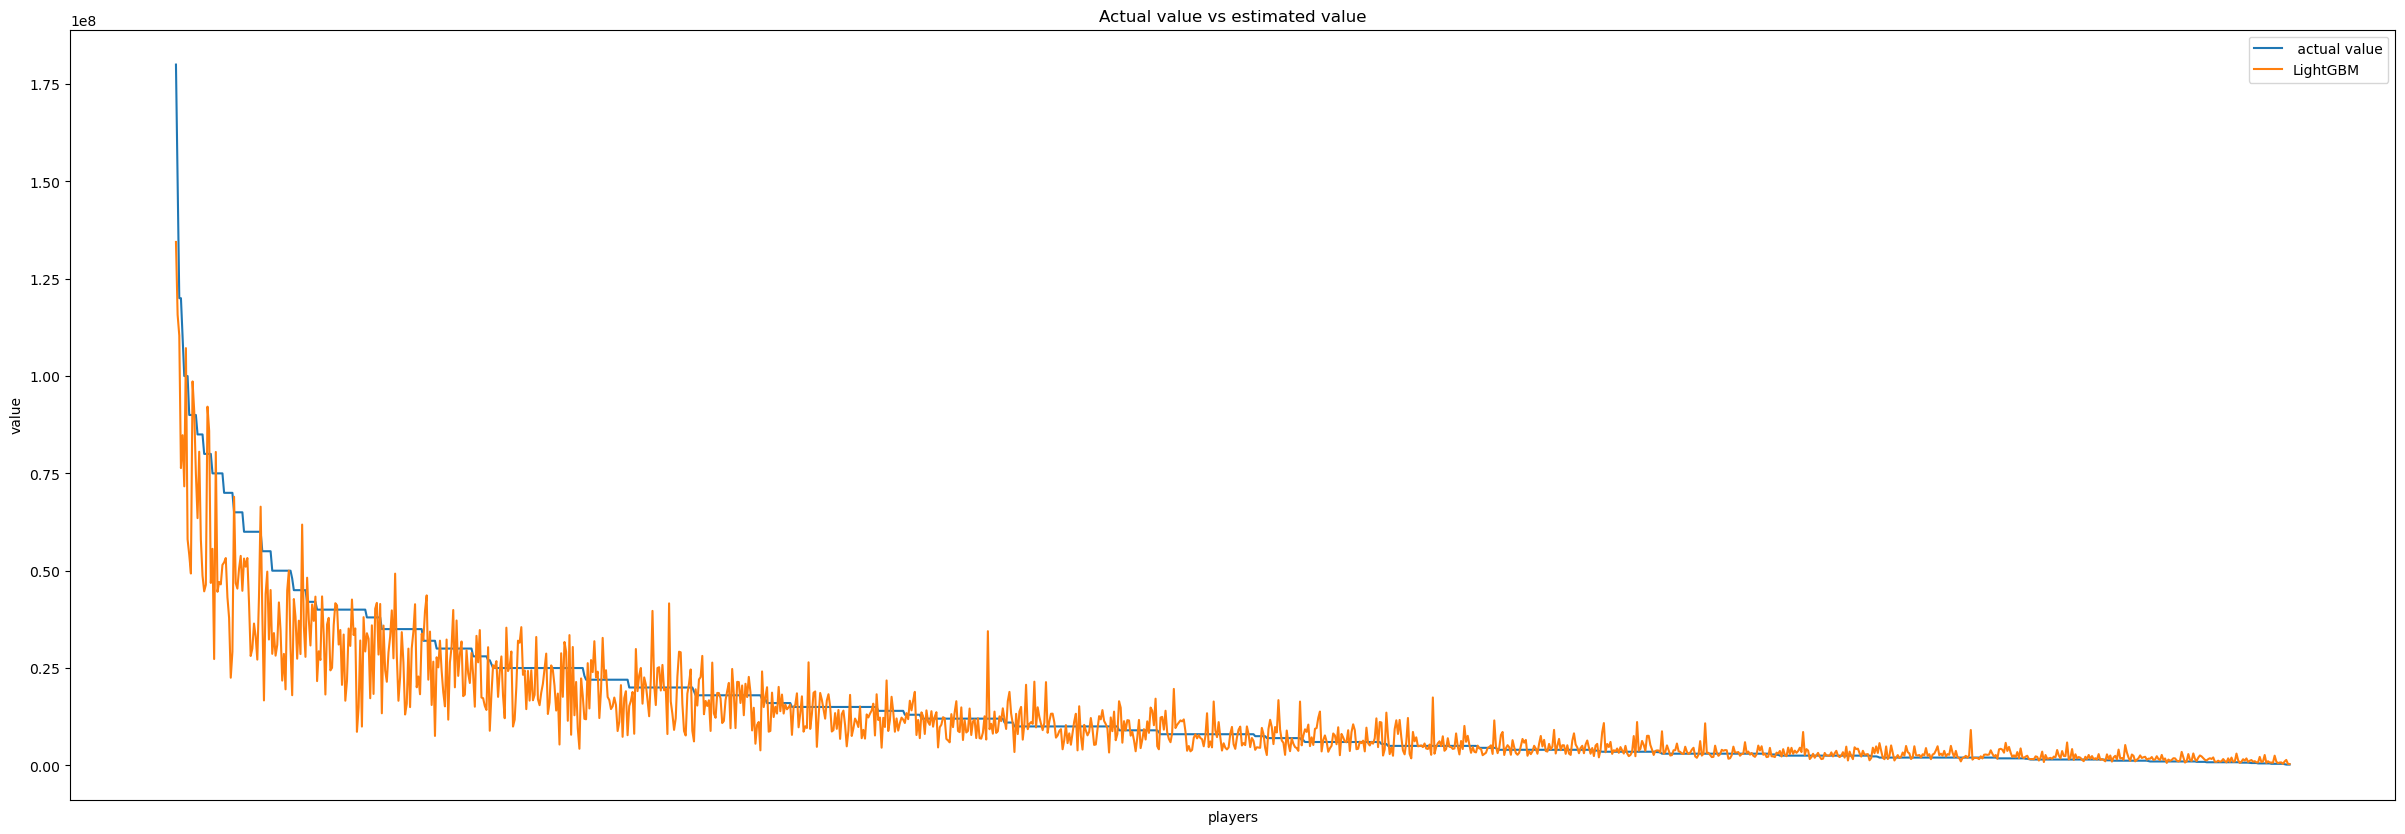

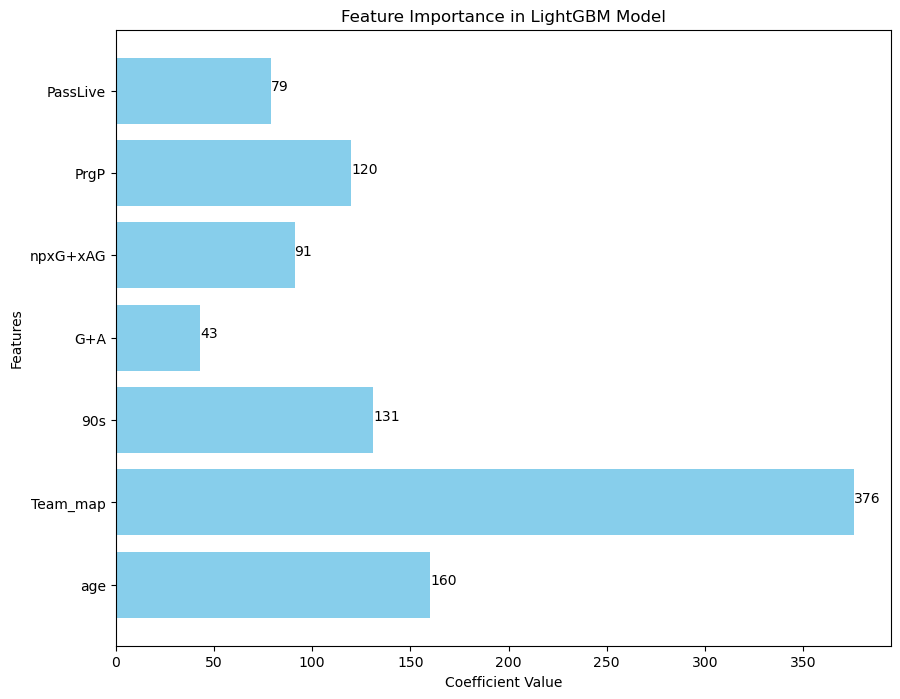

In [52]:

estimated_value = []
generalStats_pos_local['estimated_value_log'] = estimated_value_log
generalStats_pos_local['estimated_value_log'] = generalStats_pos_local['estimated_value_log'].astype(float)
print(type(generalStats_pos_local['estimated_value_log']))
generalStats_pos_local['diff_log'] = generalStats_pos_local['value_log'] - generalStats_pos_local['estimated_value_log']
print(generalStats_pos_local['diff_log'])

for value in generalStats_pos_local['estimated_value_log']:
    estimated_value.append(math.exp(value))
generalStats_pos_local['estimated_value'] = estimated_value
generalStats_pos_local['value'] = generalStats_pos_local['value'].astype(int)
generalStats_pos_local['diff'] = generalStats_pos_local['value'] - generalStats_pos_local['estimated_value']
print(type(generalStats_pos_local['value']))
print(generalStats_pos_local['diff'])

generalStats_pos_local['absolute_diff'] = abs(generalStats_pos_local['diff'])

bestvalued_50 = generalStats_pos_local[['Player','value','estimated_value','diff','absolute_diff']].nlargest(n=50,columns = 'absolute_diff')
print(bestvalued_50)
actual_values = bestvalued_50.head(15)['value']
estimated_values = bestvalued_50.head(15)['estimated_value']
labels = bestvalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels) 
print('Mean difference: ', np.mean(generalStats_pos_local['absolute_diff']))
plt.legend()

plt.show()
plt.figure(figsize=(30, 10))  
plt.xlabel('players')
plt.ylabel('value')
plt.title('Actual value vs estimated value')
plt.xticks([])
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['value'], label=' actual value')
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['estimated_value'], label='LightGBM')


plt.legend()
plt.show()
coefficients = model.feature_importances_

# Assuming feature names are like 'feature1', 'feature2', etc.
feature_names = selected_fetures

# Step 4: Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, coefficients, color='skyblue')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance in LightGBM Model')

# Adding the coefficient values on the bars
for index, value in enumerate(coefficients):
    ax.text(value, index, str(round(value, 2)))

plt.show()

In [53]:
metrics = calculate_revised_metrics(y_test, y_test_pred)
print(metrics)

{'MAE': 0.4531831595204969, 'MSE': 0.33899322465254933, 'RMSE': 0.5822312467160702, 'R^2': 0.7855123673791792, 'MAPE': 2.961980465039082, 'MSLE': 0.001297817265114203, 'Median AE': 0.3733456105956279}


In [54]:
model.booster_.save_model('E:/Inzynierka/mode.txt')
print(model)

LGBMRegressor(min_child_samples=5, num_leaves=11, reg_alpha=0.5, reg_lambda=0.1)
